In [1]:
import sys

import os
from utils import proc_minimap_res, proc_minimap_identity, Create

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random 

In [8]:
def get_idx(gt_read_idx_file, comb_idx_file):
    gtruth = {}
    with open(gt_read_idx_file, "r") as gt_fd:
        for line in gt_fd:
            [start, end] = line.strip().split(",")[-2:]
            answer = []
            for ans in line.strip().split(",")[:-2]:
                answer.append(ans.replace(" ", "\t").split("\t")[0])
            answer_str = ",".join(answer)
            answer = ",".join(line.strip().split(",")[:-2])
            for i in range(int(start), int(end) + 1):
                gtruth[str(i)] = answer_str
        gt_fd.close()

    comb_idx2name = []
    with open(comb_idx_file, "r") as idx_fd:
        for line in idx_fd:
            comb_idx2name.append(line.strip())
        idx_fd.close()
    return gtruth, comb_idx2name

In [3]:
def eval_minimap(aln_file: str, gtruth: dict, comb_idx2name: list):
    aln_mapping = proc_minimap_identity(aln_file)
    num_uniq_correct = 0
    num_amb_correct = 0
    num_incorrect = 0
    num_miss = 0
    for rid, answer in gtruth.items():
        ridxs = aln_mapping.get(rid, [])
        if ridxs == []:
            num_miss += 1
        else:
            found = False
            sub_combs = []
            for ridx in ridxs:
                alt_solution = comb_idx2name[ridx]
                if alt_solution == answer:
                    found = True
                else:
                    sub_combs.append(alt_solution)
            if found:
                if len(ridxs) == 1:
                    num_uniq_correct += 1
                else:
                    num_amb_correct += 1
            else:
                num_incorrect += 1
    
    precision_uniq = round(100 * num_uniq_correct / len(aln_mapping.keys()), 3)
    recall_uniq = round(100 * num_uniq_correct / len(gtruth.keys()), 3)

    precision_all = round(100 * (num_uniq_correct + num_amb_correct) / len(aln_mapping.keys()), 3)
    recall_all = round(100 * (num_uniq_correct + num_amb_correct) / len(gtruth.keys()), 3)

    return precision_uniq, recall_uniq, precision_all, recall_all

In [13]:
def eval_method(qry_total: str,  gtruth: dict):
    # ignore fails
    qry_mapping = {}
    with open(qry_total, "r") as qfd:
        for line in qfd:
            answer = ",".join(line.strip().split(",")[1:])
            if answer == "fail":
                continue
            rid = line.strip().split(",")[0]
            qry_mapping[rid] = answer
        qfd.close()
    num_uniq_correct = 0
    num_amb_correct = 0
    num_incorrect = 0
    num_miss = 0

    for rid, answer in gtruth.items():
        if rid not in qry_mapping:
            num_miss += 1
        else:
            alt_solution = qry_mapping[rid]
            if alt_solution == answer:
                num_uniq_correct += 1
            else:
                num_incorrect += 1
    
    precision = round(100 * num_uniq_correct / len(qry_mapping.keys()), 3)
    recall = round(100 * num_uniq_correct / len(gtruth.keys()), 3)
    
    return precision, recall
    


In [5]:
def append_dict(d: dict, e, p, r, eve):
    d["Error rate (%)"].append(e)
    d["Precision (%)"].append(p)
    d["Recall (%)"].append(r)
    d["Event"].append(eve)

In [ ]:
comb_idx_file="aMFx4_comb_idx.txt"
prefix=""

dict_t11134_n2000 = {"Error rate (%)": [], "Precision (%)": [], "Recall (%)": [], "Event": []}
X = []
Yp = []
Yr = []
for i in range(0, 11):
    qry_total = f"simulation/sim_t11134_n2000_e{str(i)}/qry_total.csv"
    gt_read_idx_file=f"simulation/sim_t11134_n2000_e{str(i)}_read_idx.txt"
    aln_file=f"simulation_mmp/mmp_sim_t11134_n2000_e{str(i)}.paf"

    gtruth, comb_idx2name = get_idx(gt_read_idx_file, comb_idx_file)
    [p, r] = eval_method(qry_total, gtruth)
    append_dict(dict_t11134_n2000, i, p, r, "Method")

    [p_uniq, r_uniq, p_all, r_all] = eval_minimap(aln_file, gtruth, comb_idx2name)
    append_dict(dict_t11134_n2000, i, p_uniq, r_uniq, "Minimap2 (Unique)")
    append_dict(dict_t11134_n2000, i, p_all, r_all, "Minimap2 (All)")

    

pd_t11134_n2000 = pd.DataFrame(dict_t11134_n2000)

fig, axes = plt.subplots(ncols=2)
fig.set_figheight(6)
fig.set_figwidth(12)
sns.lineplot(data=pd_t11134_n2000, x="Error rate (%)", y="Precision (%)", hue="Event", style="Event", ax=axes[0], markers=True, dashes=False)
axes[0].set_ylim(0, 110)
axes[0].set_yticks(range(0, 110, 10))
axes[0].set_title("2000 reads, 5 type, 1:1:1:3:4")

sns.lineplot(data=pd_t11134_n2000, x="Error rate (%)", y="Recall (%)", hue="Event", style="Event", ax=axes[1], markers=True, dashes=False)
axes[1].set_ylim(0, 110)
axes[1].set_yticks(range(0, 110, 10))
axes[1].set_title("2000 reads, 5 type, 1:1:1:3:4")


plt.show()


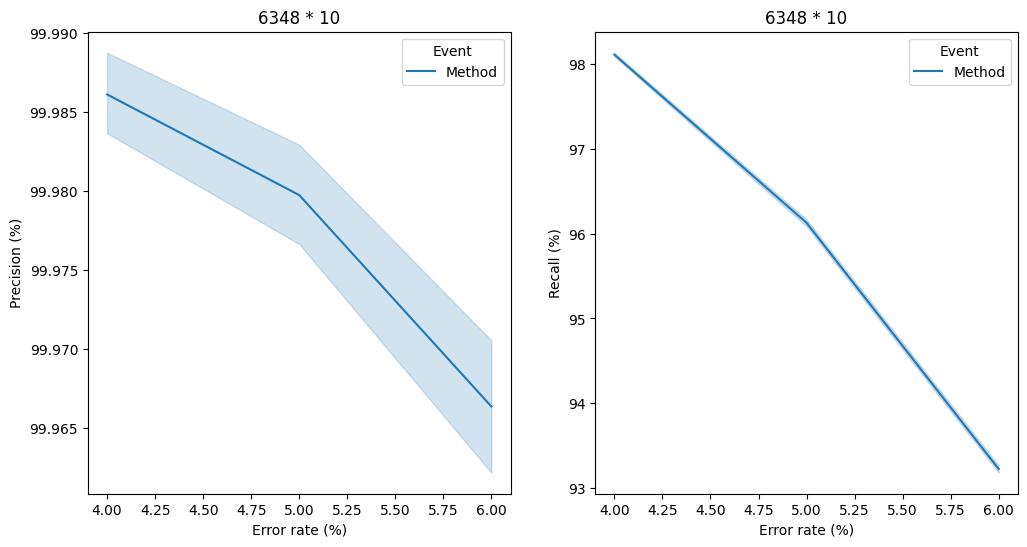

    Error rate (%)  Precision (%)  Recall (%)  Trial   Event
0                4         99.994      98.070      0  Method
1                5         99.977      96.150      0  Method
2                6         99.966      93.269      0  Method
3                4         99.990      98.086      1  Method
4                5         99.970      96.016      1  Method
5                6         99.954      93.133      1  Method
6                4         99.986      98.116      2  Method
7                5         99.977      96.139      2  Method
8                6         99.965      93.266      2  Method
9                4         99.984      98.070      3  Method
10               5         99.980      96.233      3  Method
11               6         99.976      93.170      3  Method
12               4         99.984      98.187      4  Method
13               5         99.985      96.122      4  Method
14               6         99.976      93.181      4  Method
15               4      

In [14]:
def append_dict_trail(d: dict, e, p, r, trl, eve):
    d["Error rate (%)"].append(e)
    d["Precision (%)"].append(p)
    d["Recall (%)"].append(r)
    d["Trial"].append(trl)
    d["Event"].append(eve)


comb_idx_file="../aMFx4_comb_idx.txt"
prefix=""

dict_tall_e4_6 = {"Error rate (%)": [], "Precision (%)": [], "Recall (%)": [], "Trial": [], "Event": []}
X = []
Yp = []
Yr = []
for i in range(0, 11):
    qry_total_e4 = f"../results/sim_plschain_all/res_tall_n10_e4_s{str(i)}/qry_total.csv"
    qry_total_e5 = f"../results/sim_plschain_all/res_tall_n10_e5_s{str(i)}/qry_total.csv"
    qry_total_e6 = f"../results/sim_plschain_all/res_tall_n10_e6_s{str(i)}/qry_total.csv"

    gt_read_idx_file_e4=f"../../db_query/simulation/cp-out/sim_tall_n10_e4_s{i}_read_idx.txt"
    gt_read_idx_file_e5=f"../../db_query/simulation/cp-out/sim_tall_n10_e5_s{i}_read_idx.txt"
    gt_read_idx_file_e6=f"../../db_query/simulation/cp-out/sim_tall_n10_e6_s{i}_read_idx.txt"

    gtruth, comb_idx2name = get_idx(gt_read_idx_file_e4, comb_idx_file)
    [p4, r4] = eval_method(qry_total_e4, gtruth)
    append_dict_trail(dict_tall_e4_6, 4, p4, r4, i, "Method")

    gtruth, comb_idx2name = get_idx(gt_read_idx_file_e5, comb_idx_file)
    [p5, r5] = eval_method(qry_total_e5, gtruth)
    append_dict_trail(dict_tall_e4_6, 5, p5, r5, i, "Method")

    gtruth, comb_idx2name = get_idx(gt_read_idx_file_e6, comb_idx_file)
    [p6, r6] = eval_method(qry_total_e6, gtruth)
    append_dict_trail(dict_tall_e4_6, 6, p6, r6, i, "Method")


    

pd_tall_e4_6 = pd.DataFrame(dict_tall_e4_6)


fig, axes = plt.subplots(ncols=2)
fig.set_figheight(6)
fig.set_figwidth(12)
sns.lineplot(data=pd_tall_e4_6, x="Error rate (%)", y="Precision (%)", hue="Event", ax=axes[0], markers=True, dashes=False)
# axes[0].set_ylim(0, 110)
# axes[0].set_yticks(range(0, 110, 10))
axes[0].set_title("6348 * 10")

sns.lineplot(data=pd_tall_e4_6, x="Error rate (%)", y="Recall (%)", hue="Event", ax=axes[1], markers=True, dashes=False)
# axes[1].set_ylim(0, 110)
# axes[1].set_yticks(range(0, 110, 10))
axes[1].set_title("6348 * 10")


plt.show()

# accuracy plot

# 5%

# 6k, 100 reads per comb, 10 trails, get conf interval.
print(pd_tall_e4_6)

